In [1]:
import numpy as np
import cv2
import os
import random
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Function to extract label from image filename
def extract_label(img_path, train=True):
    filename, _ = os.path.splitext(os.path.basename(img_path))
    subject_id, etc = filename.split('__')
    if train:
        gender, lr, finger, _, _ = etc.split('_')
    else:
        gender, lr, finger, _ = etc.split('_')

    gender = 0 if gender == 'M' else 1  # 0 for Male, 1 for Female
    lr = 0 if lr == 'Left' else 1       # 0 for Left, 1 for Right
    finger_mapping = {'thumb': 0, 'index': 1, 'middle': 2, 'ring': 3, 'little': 4}
    finger = finger_mapping.get(finger, -1)  # Map fingers to numerical values

    return np.array([gender, lr, finger], dtype=np.uint16)

In [3]:
IMG_SIZE = 96

# Function to load images and labels from a directory
def load_data(path, train=True):
    print("Loading data from:", path)
    data = []
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            img_resize = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            label = extract_label(os.path.join(path, img), train)
            data.append([label, img_resize])
        except Exception as e:
            pass
    return data

In [4]:
# Paths to datasets
Real_path = "../input/socofing/SOCOFing/Real"
Easy_path = "../input/socofing/SOCOFing/Altered/Altered-Easy"
Medium_path = "../input/socofing/SOCOFing/Altered/Altered-Medium"
Hard_path = "../input/socofing/SOCOFing/Altered/Altered-Hard"

# Loading data
easy_data = load_data(Easy_path, train=True)
medium_data = load_data(Medium_path, train=True)
hard_data = load_data(Hard_path, train=True)
test = load_data(Real_path, train=False)

# Combine and shuffle data
data = np.concatenate([easy_data, medium_data, hard_data], axis=0)
random.shuffle(data)
random.shuffle(test)

Loading data from: ../input/socofing/SOCOFing/Altered/Altered-Easy
Loading data from: ../input/socofing/SOCOFing/Altered/Altered-Medium
Loading data from: ../input/socofing/SOCOFing/Altered/Altered-Hard
Loading data from: ../input/socofing/SOCOFing/Real


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [5]:
X, y = [], []
for label, feature in data:
    y.append(label)
    X.append(feature)

X_train = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255  # Normalize images
y_train = np.array(y)

In [6]:
# Function to create a base CNN model
def create_base_cnn(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    return inputs, x

In [7]:
# Create separate models for each task
input_shape = (IMG_SIZE, IMG_SIZE, 1)
inputs, base_output = create_base_cnn(input_shape)

In [8]:
# Gender model
gender_output = Dense(1, activation='sigmoid', name='gender_output')(base_output)
gender_model = Model(inputs=inputs, outputs=gender_output)
gender_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Hand model
hand_output = Dense(1, activation='sigmoid', name='hand_output')(base_output)
hand_model = Model(inputs=inputs, outputs=hand_output)
hand_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Finger model
finger_output = Dense(5, activation='softmax', name='finger_output')(base_output)
finger_model = Model(inputs=inputs, outputs=finger_output)
finger_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Function to get predictions from all three models
def get_combined_output(X):
    gender_pred = (gender_model.predict(X) > 0.5).astype(int)
    hand_pred = (hand_model.predict(X) > 0.5).astype(int)
    finger_pred = np.argmax(finger_model.predict(X), axis=1)
    return np.concatenate([gender_pred, hand_pred, finger_pred.reshape(-1, 1)], axis=1)

In [10]:
# Example prediction on test data
X_test = np.array([feature for _, feature in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255
y_test_combined = np.array([label for label, _ in test])

combined_predictions = get_combined_output(X_test)

In [11]:
# Evaluate the combined predictions
combined_accuracy = accuracy_score(y_test_combined.flatten(), combined_predictions.flatten())
print(f"Combined Model Accuracy: {combined_accuracy:.4f}")

Combined Model Accuracy: 0.3023


In [12]:
# Separate Accuracy, Precision, Recall, and Confusion Matrix for Each Task

def evaluate_task(y_true, y_pred, task_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"{task_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {task_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Gender Task - Accuracy: 0.2050, Precision: 0.1025, Recall: 0.5000


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


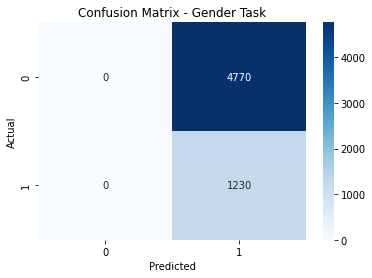

In [13]:
# Evaluate Gender Task
evaluate_task(y_test_combined[:, 0], combined_predictions[:, 0], "Gender Task")

Hand Task - Accuracy: 0.4987, Precision: 0.4163, Recall: 0.4987


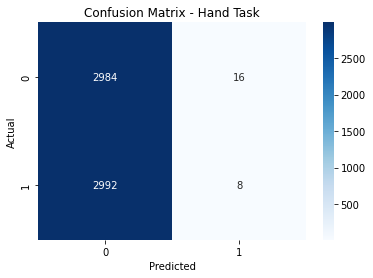

In [14]:
# Evaluate Hand Task
evaluate_task(y_test_combined[:, 1], combined_predictions[:, 1], "Hand Task")

Finger Task - Accuracy: 0.2033, Precision: 0.1280, Recall: 0.2033


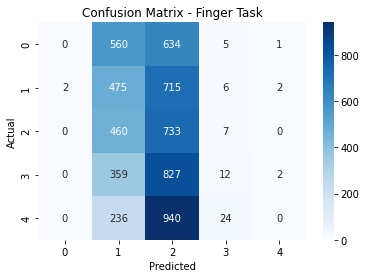

In [15]:
# Evaluate Finger Task
evaluate_task(y_test_combined[:, 2], combined_predictions[:, 2], "Finger Task")